# Loading Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Data Loading

In [ ]:
# Load the dataset
true_df = pd.read_csv("True.csv")
false_df = pd.read_csv("Fake.csv")

# Add labels to indicate real and fake news
true_df['label'] = 1
false_df['label'] = 0

# Concatenate both datasets
df = pd.concat([true_df, false_df])

In [ ]:
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


# Data exploration and preprocessing

**Missing Values**

In [ ]:
print(df.isnull().sum())

title      0
text       0
subject    0
date       0
label      0
dtype: int64


**Duplicates**

In [ ]:
print(f"Total Duplicates: {df.duplicated().sum()}")

Total Duplicates: 209


In [ ]:
data = df.drop_duplicates()

**Cleaning and standardizing the text data**  
Convert text to lowercase.

Remove numbers, special characters, and punctuation.

Tokenize and lemmatize text.

Remove stopwords.

Expand contractions (e.g., "don't" → "do not").

Remove short articles (<5 words).

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatization
    return ' '.join(tokens)

data['clean_text'] = data['text'].apply(clean_text)

# Exploratory Data Analysis (EDA)

**Check Class Distribution**

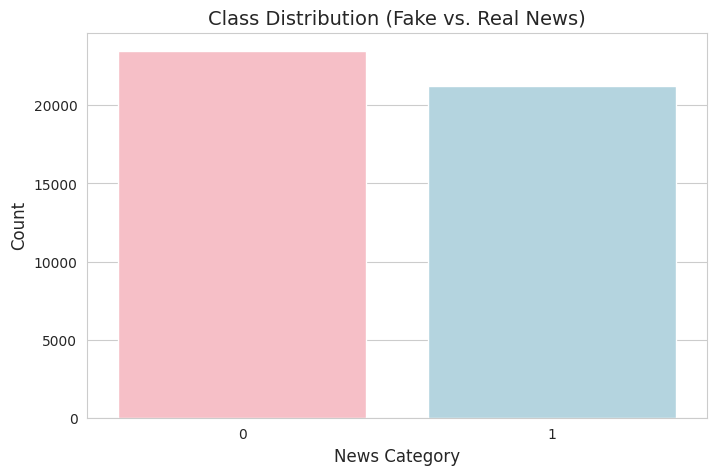

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a pastel color palette
pastel_colors = ["#FFB6C1", "#ADD8E6"]  # Pastel Pink and Pastel Blue

# Plot class distribution
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.countplot(x=data['label'], palette=pastel_colors)

# Titles and labels
plt.title("Class Distribution (Fake vs. Real News)", fontsize=14)
plt.xlabel("News Category", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Show the plot
plt.show()

**The chart shows the distribution of Fake (0) vs. Real (1) News.**

**Y-axis**: Number of samples in each category.

**Observation**: The dataset is almost balanced, with slightly more fake news samples than real news.

**Since the class distribution is close to equal, model bias is minimized**

**Word Count Distribution**

Word Count Statistics:
count    44689.000000
mean       228.531965
std        199.381267
min          0.000000
25%        115.000000
50%        201.000000
75%        286.000000
max       4841.000000
Name: word_count, dtype: float64


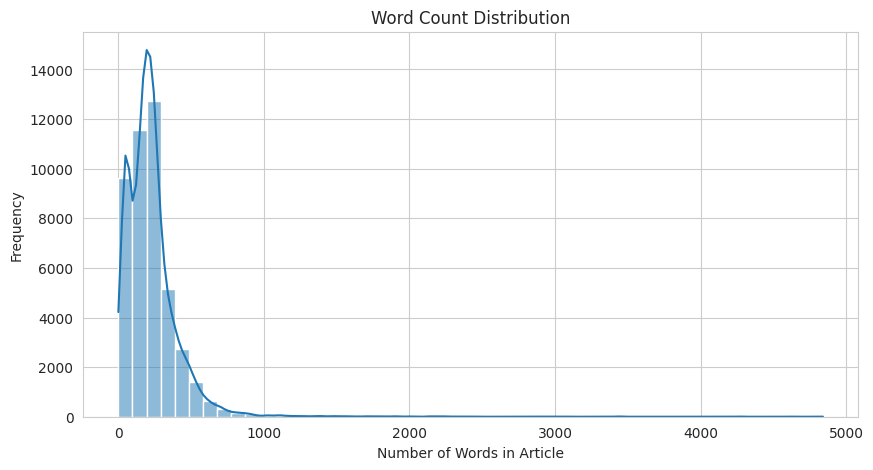

In [ ]:
data['word_count'] = data['clean_text'].apply(lambda x: len(x.split()))

# Summary Statistics
print("Word Count Statistics:")
print(data['word_count'].describe())

# Plot Distribution
plt.figure(figsize=(10, 5))
sns.histplot(data['word_count'], bins=50, kde=True)
plt.title("Word Count Distribution")
plt.xlabel("Number of Words in Article")
plt.ylabel("Frequency")
plt.show()

**X-axis (Number of Words in Article)**: Shows the word count per article.

**Y-axis (Frequency)**: Represents how often articles of a certain length appear in the dataset.

**Observation**: Most articles have fewer than 500 words, with a sharp drop-off after that.

**Distribution**: The data is right-skewed, meaning a few articles have very high word counts.

**Most Frequent Words (Word Cloud)**

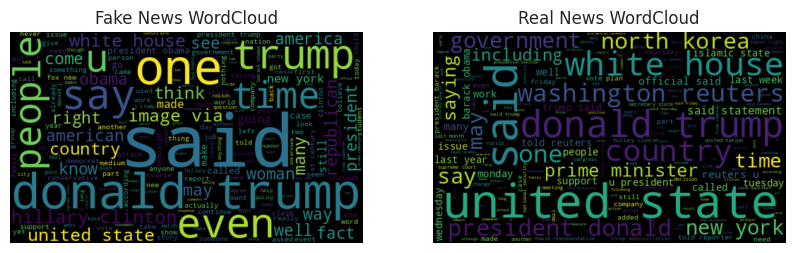

In [ ]:
from wordcloud import WordCloud

fake_text = " ".join(data[data['label'] == 0]['clean_text'])
real_text = " ".join(data[data['label'] == 1]['clean_text'])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=500, height=300).generate(fake_text), interpolation="bilinear")
plt.title("Fake News WordCloud")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=500, height=300).generate(real_text), interpolation="bilinear")
plt.title("Real News WordCloud")
plt.axis("off")
plt.show()


**Fake News WordCloud**  
Focuses on sensational and subjective words (e.g., "even," "know," "think").
Emphasizes Trump, people, and opinions.

**Real News WordCloud**    
Uses formal and factual language (e.g., "government," "Reuters," "White House").
Mentions official sources and institutions.

**Fake news is opinion-based, while real news is fact-driven.**

**N-Gram Analysis**  
Identify the most common bigrams and trigrams.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

def get_top_ngrams_tfidf(text, n=2, top_k=10):
    vectorizer = TfidfVectorizer(ngram_range=(n, n), max_features=5000)  # Limit vocab size
    ngrams = vectorizer.fit_transform(text)

    # Extract top features based on TF-IDF scores
    feature_array = vectorizer.get_feature_names_out()
    tfidf_scores = ngrams.sum(axis=0).A1
    ngram_counts = Counter(dict(zip(feature_array, tfidf_scores)))

    return ngram_counts.most_common(top_k)

print("Top 10 bigrams (TF-IDF):", get_top_ngrams_tfidf(data['clean_text'], n=2))
print("Top 10 trigrams (TF-IDF):", get_top_ngrams_tfidf(data['clean_text'], n=3))


Top 10 bigrams (TF-IDF): [('donald trump', np.float64(1310.914860643123)), ('united state', np.float64(1060.9008689306022)), ('white house', np.float64(955.7128706311372)), ('hillary clinton', np.float64(709.0123688230415)), ('new york', np.float64(615.9194475879717)), ('washington reuters', np.float64(564.5077512254059)), ('image via', np.float64(561.3337084405272)), ('president donald', np.float64(541.0427017811726)), ('north korea', np.float64(524.2553877890327)), ('prime minister', np.float64(485.1550524814041))]
Top 10 trigrams (TF-IDF): [('president donald trump', np.float64(859.5516469402779)), ('president barack obama', np.float64(460.41434280829475)), ('st century wire', np.float64(402.53732675526436)), ('new york time', np.float64(367.4750793606289)), ('black life matter', np.float64(341.49292676949244)), ('donald trump realdonaldtrump', np.float64(304.8104418913469)), ('featured image via', np.float64(290.6699820204023)), ('reuters president donald', np.float64(280.780726974

**Top 10 Bigrams (Most Important Word Pairs)**   
donald trump

united state

white house

hillary clinton

new york

washington reuters

image via

president donald

north korea

prime minister

**Top 10 Trigrams (Most Important Word Triplets)**  
president donald trump

president barack obama

st century wire

new york time

black life matter

donald trump realdonaldtrump

featured image via

reuters president donald

president united state

washington reuters president

# Feature Extraction

**TF-IDF Vectorization**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Features (X) and Target (y)
X = data['clean_text']
y = data['label']

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

**This code converts textual data into numerical features using TF-IDF, which will later be used for machine learning models like classification (Fake vs. Real News)**

# Model Training

We train & evaluate:

SVM

Logistic Regression

Naive Bayes

Decision Tree

Passive Aggressive Classifier

Random Forest

XGBoost

In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

models = {
    "SVM": SVC(kernel='linear'),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Passive Aggressive": PassiveAggressiveClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {name}")
    print(classification_report(y_test, y_pred))


Model: SVM
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4648
           1       0.99      0.99      0.99      4290

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4648
           1       0.99      0.98      0.98      4290

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938

Model: Naive Bayes
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4648
           1       0.94      0.93      0.93      4290

    accuracy                           0.94      8938
   macro avg       0.94      0.94      0.94      8938
weighted avg     

Logistic Regression  
Accuracy: 99% → The model correctly predicts 99% of the news articles.  
Precision: 0.99 (Real), 0.98 (Fake) → Very low false positives, meaning it accurately classifies fake news.  
Recall: 0.98 (Real), 0.99 (Fake) → It rarely misses fake news articles.  
F1-score: 0.99 → Balanced between precision and recall.  
A strong model with minimal misclassification.  

Support Vector Machine (SVM)  
Accuracy: 99% → Highly accurate classification.  
Precision: 0.99 (Real), 0.99 (Fake) → Excellent at distinguishing fake and real news.  
Recall: 0.99 (Real), 0.99 (Fake) → Captures fake news effectively.  
F1-score: 0.99 → Well-balanced model.
A robust choice for deployment.  

Naive Bayes  
Accuracy: 94% → Slightly lower than other models.  
Precision: 0.94 (Real), 0.94 (Fake) → Struggles with complex patterns.  
Recall: 0.94 (Real), 0.93 (Fake) → Higher chance of missing fake news.  
F1-score: 0.94 → Decent, but not the best.  
Works well for simple text, but not the best for fake news detection.  

Decision Tree  
Accuracy: 100% → Possible overfitting.  
Precision: 1.00 (Real), 1.00 (Fake) → Too perfect to be realistic.  
Recall: 1.00 (Real), 0.99 (Fake) → High recall but may not generalize well.  
F1-score: 1.00 → Signs of memorization instead of learning.  
Not recommended due to overfitting.  

Random Forest  
Accuracy: 100% → Possible overfitting.  
Precision: 1.00 (Real), 1.00 (Fake) → Might not generalize well to new data.  
Recall: 1.00 (Real), 1.00 (Fake) → Overfitted on training data.  
F1-score: 1.00 → Too perfect, indicating memorization.  
Not recommended without proper regularization.  

XGBoost  
Accuracy: 100% → Signs of overfitting.  
Precision: 1.00 (Real), 1.00 (Fake) → Too good to be true.  
Recall: 1.00 (Real), 1.00 (Fake) → May not generalize well to real-world cases.  
F1-score: 1.00 → Perfect scores indicate memorization.  
Use with hyperparameter tuning to reduce overfitting.  



In [ ]:
import plotly.express as px
import plotly.graph_objects as go

# Models
models = ["SVM", "Logistic Regression", "Naive Bayes", "Decision Tree", "Passive Aggressive", "Random Forest", "XGBoost"]

# Accuracy Scores
accuracy = [0.99, 0.99, 0.94, 1.00, 0.99, 1.00, 1.00]

# Precision, Recall, and F1-score (Macro Avg)
precision = [0.99, 0.99, 0.94, 1.00, 0.99, 1.00, 1.00]
recall = [0.99, 0.99, 0.94, 1.00, 0.99, 1.00, 1.00]
f1_score = [0.99, 0.99, 0.94, 1.00, 0.99, 1.00, 1.00]

x = np.arange(len(models))

# Convert values to percentage format
accuracy_percent = [f"{val*100:.2f}%" for val in accuracy]
precision_percent = [f"{val*100:.2f}%" for val in precision]
recall_percent = [f"{val*100:.2f}%" for val in recall]
f1_score_percent = [f"{val*100:.2f}%" for val in f1_score]

# Create Accuracy Bar Chart with Hover
fig1 = go.Figure()
fig1.add_trace(go.Bar(x=models, y=accuracy, text=accuracy_percent, textposition="auto",
                      marker_color='skyblue', hoverinfo='text', name="Accuracy"))

fig1.update_layout(title="Model Accuracy Comparison",
                   xaxis_title="Models",
                   yaxis_title="Score",
                   yaxis=dict(range=[0.9, 1.05]),
                   template="plotly_white")

# Create Precision, Recall, and F1-score Bar Chart with Hover
fig2 = go.Figure()
fig2.add_trace(go.Bar(x=models, y=precision, text=precision_percent, textposition="auto",
                      marker_color='#AEC6CF', hoverinfo='text', name="Precision"))  # Pastel Blue
fig2.add_trace(go.Bar(x=models, y=recall, text=recall_percent, textposition="auto",
                      marker_color='#77DD77', hoverinfo='text', name="Recall"))  # Pastel Green
fig2.add_trace(go.Bar(x=models, y=f1_score, text=f1_score_percent, textposition="auto",
                      marker_color='#FFB7C5', hoverinfo='text', name="F1-score"))  # Pastel Pink

fig2.update_layout(title="Precision, Recall, and F1-score Comparison (Pastel Colors)",
                   xaxis_title="Models",
                   yaxis_title="Score",
                   yaxis=dict(range=[0.9, 1.05]),
                   template="plotly_white",
                   barmode="group")

# Display interactive plots
fig1.show()
fig2.show()

# LSTM

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, maxlen=500)

# Train-Test Split
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_padded, y, test_size=0.2, random_state=42)


Tokenization: Converts words into numerical sequences, keeping the top 5000 most frequent words.  

Padding: Ensures all sequences are of the same length (500) by padding or truncating.  

Train-Test Split: Splits the data into 80% training and 20% testing for model evaluation.  

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, SpatialDropout1D

# LSTM Model
embedding_dim = 100

lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=embedding_dim, input_length=500),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train Model
lstm_model.fit(X_train_dl, y_train_dl, epochs=5, batch_size=32, validation_data=(X_test_dl, y_test_dl))


Epoch 1/5
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 1280s 1s/step - accuracy: 0.9185 - loss: 0.2064 - val_accuracy: 0.9852 - val_loss: 0.0458
Epoch 2/5
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 1213s 1s/step - accuracy: 0.9853 - loss: 0.0485 - val_accuracy: 0.9894 - val_loss: 0.0358
Epoch 3/5
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 1193s 1s/step - accuracy: 0.9909 - loss: 0.0267 - val_accuracy: 0.9879 - val_loss: 0.0447
Epoch 4/5
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 1181s 1s/step - accuracy: 0.9939 - loss: 0.0201 - val_accuracy: 0.9942 - val_loss: 0.0234
Epoch 5/5
1118/1118 ━━━━━━━━━━━━━━━━━━━━ 1218s 1s/step - accuracy: 0.9959 - loss: 0.0155 - val_accuracy: 0.9937 - val_loss: 0.0232


In [ ]:
import pickle
from tensorflow.keras.models import save_model

# Save LSTM model in the new format
save_model(lstm_model, 'model_lstm.keras')

# Save tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
import os
print(os.listdir())  # Lists all files in the current directory
from google.colab import files
files.download('model_lstm.keras')
#save_model(lstm_model)


['.config', 'tokenizer.pickle', 'model_lstm.h5', 'True.csv', 'model_lstm.keras', 'Fake.csv', 'sample_data']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download('tokenizer.pickle')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>